In [121]:
from tools import *
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np




set_plot_style()

# Introdução

&emsp; O alto índice de faltas em agendamentos (no-shows)se torna um problmea para salões de beleza, pois gera ociosidade de profissionais, perda de receita e aumento do tempo de espera para outros clientes. A previsão antecipada de clientes com alta probabilidade de não comparecimento permite que o salão adote estratégias preventivas, como solicitação de depósito antecipado, envio de lembretes personalizados ou realocação inteligente de horários.

&emsp;Utilizei dados históricos de agendamentos para analisar padrões de comportamento e desenvolver um modelo preditivo capaz de estimar a probabilidade de no-show, apoiando decisões operacionais e melhorando a eficiência do serviço.

# Objetivo do Projeto


&emsp;Este projeto tem como objetivo desenvolver uma solução baseada em dados e estatística para prever a probabilidade de um cliente não comparecer ao seu agendamento (no-show), buscando identificar padrões comportamentais e fatores relevantes associados às faltas, permitindo que o salão tome decisões operacionais de forma mais assertiva.


&emsp;Como resultado, pretende-se criar uma ferramenta analítica que auxilie o salão a reduzir perdas financeiras por meio do aumento da taxa de ocupação dos profissionais e da melhoria da experiência dos clientes.

## Dataset



Os dados foram retirados do kaggle: [Link Text](https://www.kaggle.com/datasets/frederickferguson/hair-salon-no-show-data-set?resource=download)

In [122]:
df_hair_salon = pd.read_csv('../data/raw/hair_salon_no_show_wrangled_df.csv')
df_hair_salon.head()


,Unnamed: 0,book_tod,book_dow,book_category,book_staff,last_category,last_staff,last_day_services,last_receipt_tot,last_dow,...,last_prod_flag,last_cumrev,last_cumbook,last_cumstyle,last_cumcolor,last_cumprod,last_cumcancel,last_cumnoshow,noshow,recency
0,0,afternoon,Wednesday,STYLE,JJ,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
1,1,morning,Wednesday,COLOR,JOANNE,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
2,2,NaN,Wednesday,STYLE,JJ,COLOR,JOANNE,2,262.0,Wednesday,...,1,262,2,1,1,2,0,0,0,35
3,3,afternoon,Thursday,STYLE,KELLY,NaN,NaN,0,0.0,NaN,...,0,0,0,0,0,0,0,0,0,0
4,4,evening,Saturday,STYLE,KELLY,STYLE,KELLY,1,35.0,Thursday,...,0,35,1,1,0,0,0,0,0,9


In [123]:
df_hair_salon = df_hair_salon.drop_duplicates()
df_hair_salon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1952 entries, 0 to 1951
Data columns (total 22 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1952 non-null   int64  
 1   book_tod           1717 non-null   object 
 2   book_dow           1952 non-null   object 
 3   book_category      1952 non-null   object 
 4   book_staff         1952 non-null   object 
 5   last_category      1003 non-null   object 
 6   last_staff         1003 non-null   object 
 7   last_day_services  1952 non-null   int64  
 8   last_receipt_tot   1952 non-null   float64
 9   last_dow           1003 non-null   object 
 10  last_tod           858 non-null    object 
 11  last_noshow        1952 non-null   int64  
 12  last_prod_flag     1952 non-null   int64  
 13  last_cumrev        1952 non-null   int64  
 14  last_cumbook       1952 non-null   int64  
 15  last_cumstyle      1952 non-null   int64  
 16  last_cumcolor      1952 

## Qual é a taxa geral de no-show no dataset? (Percentual de clientes que não compareceram ao agendamento versus os que compareceram)

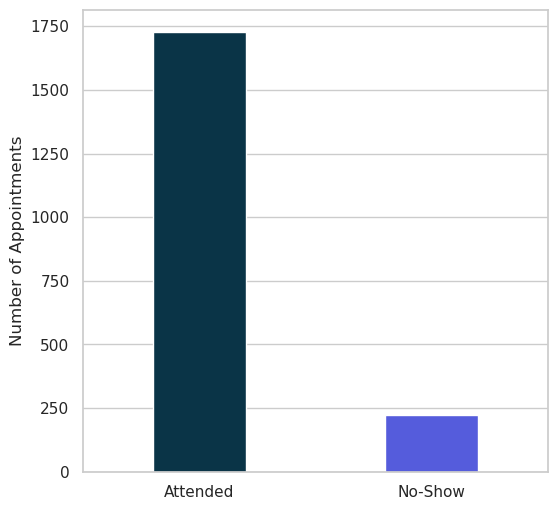

In [124]:
df_hair_salon['noshow_label'] = df_hair_salon['noshow'].map({
    0: 'Attended',
    1: 'No-Show'
})

plt.figure(figsize=(6,6))
sns.countplot(
    data=df_hair_salon,
    x='noshow_label',
    hue='noshow_label',
    legend=False,
    width=0.4
)
plt.xlabel('')
plt.ylabel('Number of Appointments')
plt.savefig("../figs/number_appointments.png", dpi=300, bbox_inches="tight")





## Existe aumento na taxa de cancelamento durantes dias da semana ou perido dos dias ??

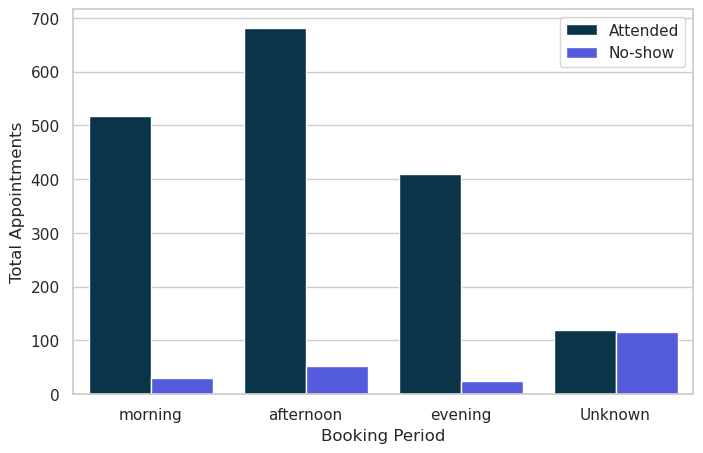

In [125]:
df_hair_salon['book_tod'] = df_hair_salon['book_tod'].fillna('Unknown')

order_period= ['morning', 'afternoon', 'evening', 'Unknown']

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_hair_salon, x='book_tod',  hue='noshow', order= order_period)
ax.legend( labels=['Attended', 'No-show'])
ax.set_xlabel('Booking Period')
ax.set_ylabel('Total Appointments')
plt.savefig("../figs/Booking_Period.png", dpi=300, bbox_inches="tight")

In [126]:
alpha = 0.05
df_valid_book_tod = df_hair_salon[df_hair_salon['book_tod'] != 'Unknown']
contingency_table = pd.crosstab(
    df_valid_book_tod['book_tod'],
    df_valid_book_tod['noshow']
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)

if p_value < alpha:
    print("Existe diferença estatisticamente significativa entre os períodos.")
else:
    print("Não há evidência estatística de diferença entre os períodos.")





Chi-square: 1.6127639283617965
p-value: 0.44647049379238923
Não há evidência estatística de diferença entre os períodos.


Para o cálculo do p-valor, os registros com valores desconhecidos foram desconsiderados, pois poderiam introduzir um viés sem agregar informações relevantes. Com p-valor > 0,05, não há evidência estatística suficiente para afirmar que o período do dia influencia o no-show.

Pensando nos dias, podemos tambem observar o comportamento dos agendamentos e cancelamento durante os dias da semana.

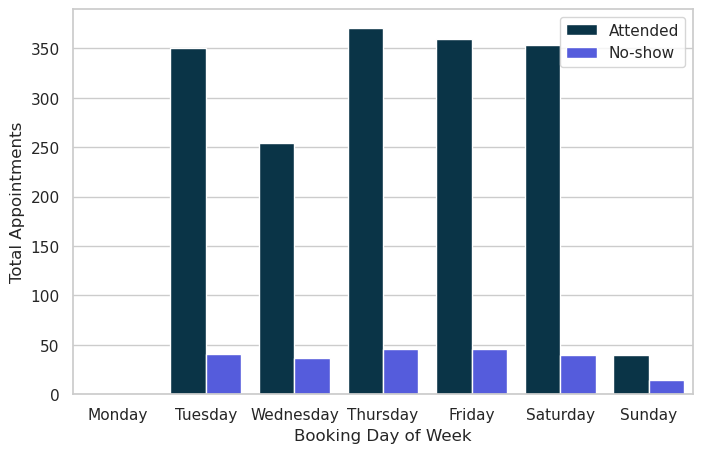

In [127]:
order_days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday',
              'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(8,5))
ax = sns.countplot(data=df_hair_salon, x='book_dow', hue='noshow', order=order_days)
ax.legend(labels=['Attended', 'No-show'])
ax.set_xlabel('Booking Day of Week')
ax.set_ylabel('Total Appointments')
plt.savefig("../figs/Booking_Week.png", dpi=300, bbox_inches="tight")

In [128]:
df_hair_salon['book_dow'].value_counts()

book_dow
Thursday     417
Friday       405
Saturday     393
Tuesday      391
Wednesday    291
Sunday        54
Monday         1
Name: count, dtype: int64

A segunda-feira foi excluído do teste, pois apresentou contagem muito pequena, comprometendo a confiabilidade do p-valor. Os demais dias foram mantidos, incluindo 'Sunday', cuja contagem é suficientemente para o teste.

In [129]:
alpha = 0.05
df_valid_book_dow = df_hair_salon[df_hair_salon['book_dow'] != 'Monday']
contingency_table = pd.crosstab(
    df_valid_book_dow['book_dow'],
    df_valid_book_dow['noshow']
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)

if p_value < alpha:
    print("Existe diferença estatisticamente significativa entre os períodos.")
else:
    print("Não há evidência estatística de diferença entre os períodos.")





Chi-square: 12.648859792196909
p-value: 0.026901209992904178
Existe diferença estatisticamente significativa entre os períodos.


O teste chi-quadrado resultou em p-valor = 0,026, indicando a existência de diferenças estatisticamente significativas entre os dias da semana. A seguir, é possível identificar quais dias contribuem mais para essa diferença utilizando a análise dos resíduos.

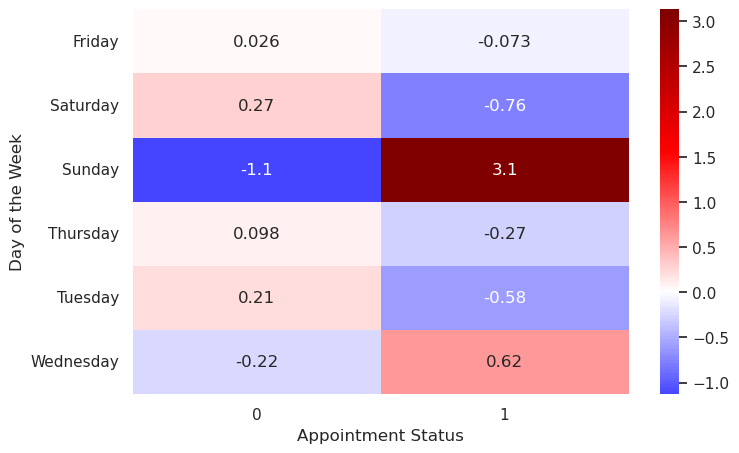

In [130]:
residuals = (contingency_table - expected) / np.sqrt(expected)
plt.figure(figsize=(8,5))
sns.heatmap(residuals, annot=True, cmap='seismic', center=0)
plt.xlabel('Appointment Status')
plt.ylabel('Day of the Week')
plt.savefig("../figs/Appointment_Status.png", dpi=300, bbox_inches="tight")


Embora o teste chi-quadrado tenha indicado diferença significativa entre os dias da semana (p = 0,026), a análise dos resíduos padronizados mostrou que essa diferença é explicada pelo domingo, que apresenta mais no-shows do que o esperado. Os demais dias não apresentaram contribuições significativas.

Também é possível analisar os horários de maior concentração de agendamentos. Esse insight é importante para estratégias de realocação de clientes com maior probabilidade de no-show. Para esta análise, os minutos serão desconsiderados, a fim de facilitar a interpretação e a visualização dos dados.

In [131]:
df_Future_book = pd.read_csv('../data/raw/Future Bookings (All Clients)0.csv')
df_Future_book['Time'] = pd.to_datetime(df_Future_book['Time'],  format='%I:%M:%S %p').dt.strftime('%H')
df_Future_book.head()

,Code,Staff,Service,Date,Time,TimeInt
0,JUNJ01,JJ,CON,03/14/2018,15,950
1,NORJ01,JJ,SHCM,03/14/2018,16,960
2,CORS01,JJ,SHCW,03/15/2018,14,850
3,KERT01,JJ,SHCW,03/15/2018,10,600
4,LEHJ01,JJ,SHCM,03/15/2018,18,1080


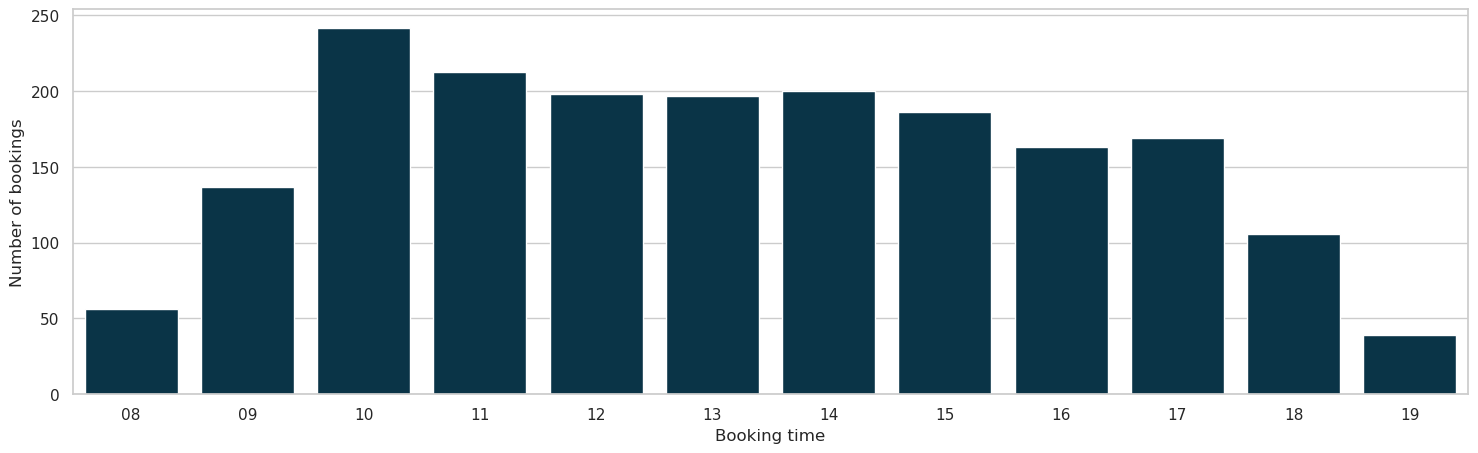

In [132]:
plt.figure(figsize=(18,5))
ax = sns.countplot(data=df_Future_book.sort_values(by = 'Time'), x='Time')
ax.set_xlabel('Booking time')
ax.set_ylabel('Number of bookings')

plt.savefig("../figs/Booking_time.png", dpi=300, bbox_inches="tight")

Como a análise do período do dia e no-show não apresentou significância estatística (p-value > 0.05), conclui-se que a probabilidade de ausência é semelhante entre manhã, tarde e noite. Dessa forma, horários com menor volume de agendamentos podem ser utilizados para realocação de clientes com maior risco de no-show, sem impacto estatisticamente relevante na taxa de comparecimento.

## Clientes que marcaram com maior antecedência (maior intervalo entre agendamento e data do atendimento) têm maior probabilidade de faltar?

In [133]:
df_client_cancel = pd.read_csv('../data/raw/Client Cancellations0.csv')
df_client_cancel.head()

,Cancel Date,Code,Service,Staff,Booking Date,Canceled By,Days
0,05/22/2018,MASA01,CFC,JOANNE,05/24/2018,ADMIN,2.0
1,06/27/2018,MASA01,CBAL,KELLY,06/27/2018,ADMIN,0.0
2,07/03/2018,MASA01,SHCM,BECKY,07/10/2018,BECKY,7.0
3,07/10/2018,MASA01,SHCC,JJ,07/11/2018,KELLY,1.0
4,07/24/2018,TRUA01,SHCM,KELLY,07/24/2018,TANYA,0.0


Foram encontrados 2 registros sem data válida de cancelamento


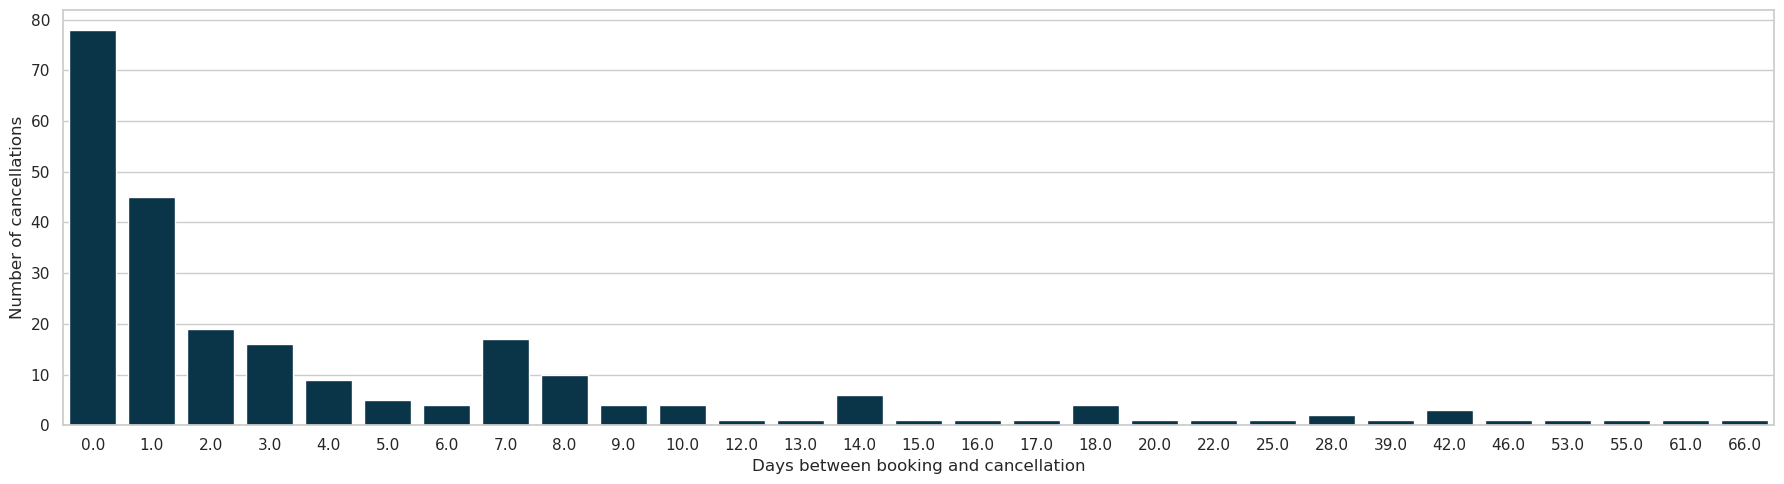

In [134]:
n_invalid = df_client_cancel['Days'].isna().sum()
print(f"Foram encontrados {n_invalid} registros sem data válida de cancelamento")

df_client_cancel = df_client_cancel[df_client_cancel['Days'] >= 0]

plt.figure(figsize=(18,5))
ax = sns.countplot(
    data=df_client_cancel.sort_values(by='Days'),
    x='Days'
)

ax.set_xlabel('Days between booking and cancellation')
ax.set_ylabel('Number of cancellations')
plt.tight_layout()
plt.savefig("../figs/between_booking_and_cancellation.png", dpi=300, bbox_inches="tight")


O intervalo entre o agendamento e o cancelamento apresentou forte concentração nos primeiros dias, com valor máximo ocorrendo no próprio dia do agendamento. Observa-se uma redução gradual na frequência de cancelamentos ao longo dos dias, com um novo agrupamento em torno de 7 dias, indicando que a primeira semana após o agendamento representa uma janela crítica para a implementação de ações preventivas.

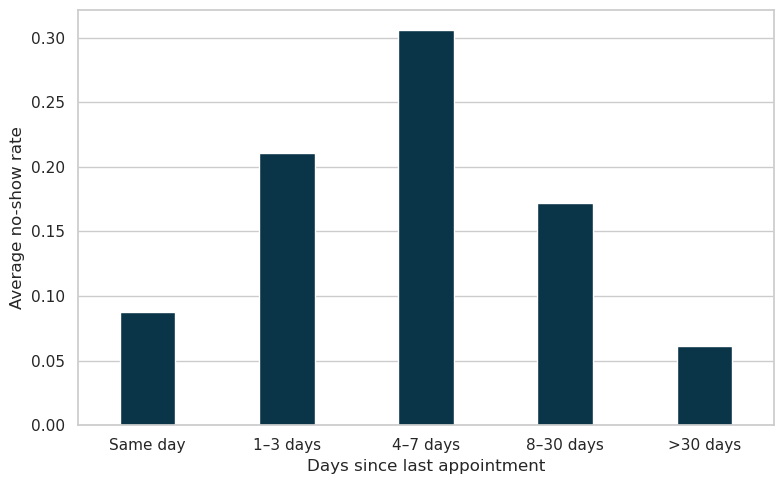

In [135]:
bins = [0, 1, 3, 7, 30, df_hair_salon['recency'].max()]
labels = ['Same day', '1–3 days', '4–7 days','8–30 days', '>30 days']

df_hair_salon = df_hair_salon.copy()
df_hair_salon['recency_group'] = pd.cut(
    df_hair_salon['recency'],
    bins=bins,
    labels=labels,
    right=False
)

recency_noshow = (
    df_hair_salon
    .groupby('recency_group', observed=True)['noshow']
    .mean()
    .reset_index()
)

plt.figure(figsize=(8,5))
ax = sns.barplot(
    data=recency_noshow,
    x='recency_group',
    y='noshow',
    width=0.4
)

ax.set_xlabel('Days since last appointment')
ax.set_ylabel('Average no-show rate')

plt.tight_layout()
plt.savefig("../figs/Days_since_last_appointment.png", dpi=300, bbox_inches="tight")


Após agrupar os valores de recency em faixas, foi calculada a média da variável noshow dentro de cada grupo. Como noshow é binária (0 ou 1), essa média representa diretamente a proporção de clientes que faltaram em cada faixa de recency. Dessa forma, é possível comparar o risco de no-show entre diferentes perfis de recorrência dos clientes.

Observa-se uma relação não linear entre recency e taxa de no-show.
O maior risco de no-show ocorre no grupo de 4 a 7 dias desde o último agendamento, que apresenta uma taxa significativamente superior aos demais intervalos.

Clientes que retornam em um intervalo muito curto (até 3 dias) tendem a apresentar menor probabilidade de falta, indicando maior comprometimento com o agendamento.
Por outro lado, o grupo de 4 a 7 dias se destaca como o segmento mais crítico, sendo um alvo prioritário para ações preventivas, como lembretes reforçados ou confirmação ativa do agendamento.

Para clientes mais esporádicos (acima de 8 dias desde o último agendamento), a taxa de no-show volta a níveis semelhantes aos observados nos clientes mais recorrentes, sugerindo um comportamento mais previsível e estável.

Por fim, outro dado interessante é observar a última categoria de serviço reservada do cliente antes da reserva atual.

In [136]:
df_hair_salon['last_category'].isna().mean()


np.float64(0.48616803278688525)

Aproximadamente 48% dos registros não possuem categoria de serviço anterior, indicando clientes sem histórico no sistema. Para fins exploratórios, estes registros foram analisados separadamente, enquanto no pipeline de modelagem essa ausência será tratada como uma categoria específica.

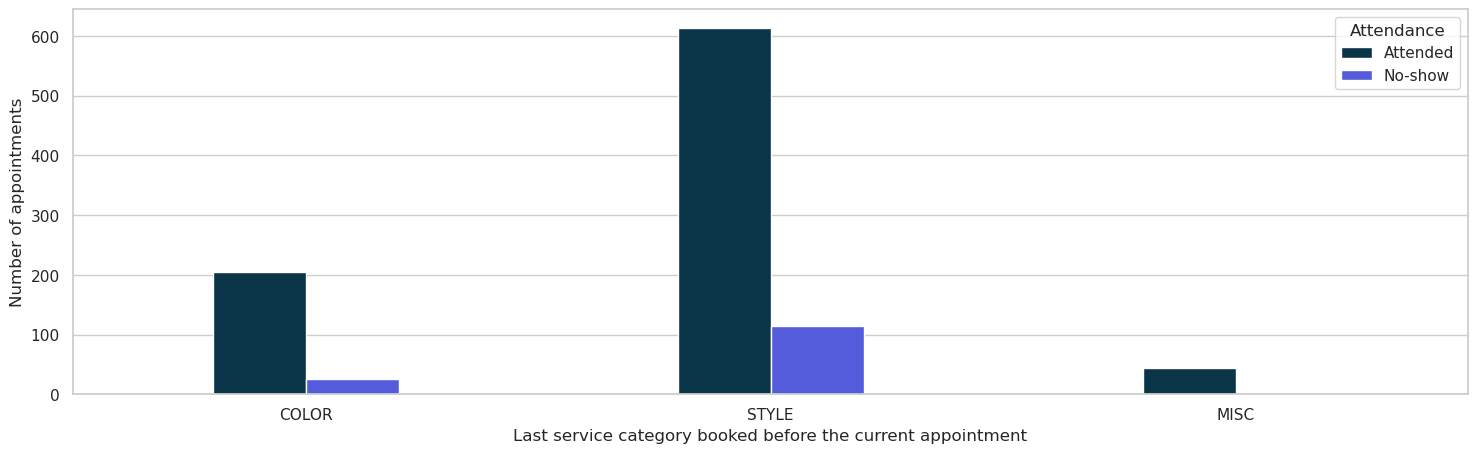

In [137]:
plt.figure(figsize=(18,5))
ax = sns.countplot(
    data=df_hair_salon,
    x='last_category',
    hue='noshow',
    width=0.4
)

ax.set_xlabel('Last service category booked before the current appointment')
ax.set_ylabel('Number of appointments')

ax.legend(title='Attendance', labels=['Attended', 'No-show'])

plt.savefig("../figs/Last_service_category.png", dpi=300, bbox_inches="tight")


In [138]:
alpha = 0.05
df_valid_last_category = df_hair_salon[df_hair_salon['last_category'] != 'MISC']
contingency_table = pd.crosstab(
    df_valid_last_category['last_category'],
    df_valid_last_category['noshow']
)

chi2, p_value, dof, expected = chi2_contingency(contingency_table)

print("Chi-square:", chi2)
print("p-value:", p_value)

if p_value < alpha:
    print("Existe diferença estatisticamente significativa entre os períodos.")
else:
    print("Não há evidência estatística de diferença entre os períodos.")





Chi-square: 2.7852378805257825
p-value: 0.0951365659539102
Não há evidência estatística de diferença entre os períodos.


O teste de independência entre a categoria do último serviço e a ocorrência de no-show não apresentou significância estatística (p = 0.095), indicando ausência de evidência suficiente para afirmar associação entre as variáveis.